In [20]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, optim 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import cycle
from collections import Counter
%matplotlib inline
import random
from torch.utils import data
import os
from tqdm import tqdm
from pyDOE import lhs

In [21]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True

In [22]:
data_x=pd.read_csv("data_x_new.csv")
data_t=pd.read_csv("data_t_new.csv")
data_xx=pd.read_csv("data_x_x.csv")

In [23]:
h10_x=data_x.iloc[:, [0]]#初值x,t
h10_t=data_x.iloc[:, [1]]
h10_R=data_x.iloc[:,[2]]#初值h实部
h10_C=data_x.iloc[:,[3]]#初值h虚部
hb_x1=data_t.iloc[:,[1]]#边值-5，t
hb_t1=data_t.iloc[:,[0]]
hb_x2=data_t.iloc[:,[2]]#边值5，t
hb_t2=data_t.iloc[:,[0]]

h20_x=data_x.iloc[:, [0]]#初值x,t
h20_t=data_x.iloc[:, [1]]
h20_R=data_x.iloc[:,[4]]#初值h实部
h20_C=data_x.iloc[:,[5]]#初值h虚部

h30_x=data_xx.iloc[:, [0]]
h30_t=data_xx.iloc[:, [1]]
h30_r1=data_xx.iloc[:, [2]]
h30_c1=data_xx.iloc[:, [3]]
h30_r2=data_xx.iloc[:, [4]]
h30_c2=data_xx.iloc[:, [5]]

In [24]:
n=100
x=lhs(1,samples=n)*20-10
t=lhs(1,samples=n)*4-2

In [25]:
X, T = np.meshgrid(x,t)

In [26]:
hf= np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

In [27]:
hf_x=hf[:,[0]]
hf_t=hf[:,[1]]

In [28]:
train10_x,test10_x,train10_t,test10_t,train10_r,test10_r,train10_c,test10_c,trainb_x1,testb_x1,trainb_t1,testb_t1,trainb_x2,testb_x2,trainb_t2,testb_t2,train20_r,test20_r,train20_c,test20_c = train_test_split(h10_x,h10_t,h10_R,h10_C,hb_x1,hb_t1,hb_x2,hb_t2,h20_R,h20_C,test_size=0.2)

train30_x,test30_x,train30_t,test30_t,train30_r1,test30_r1,train30_c1,test30_c1,train30_r2,test30_r2,train30_c2,test30_c2=train_test_split(h30_x,h30_t,h30_r1,h30_c1,h30_r2,h30_c2)


In [29]:
trainu_x, testu_x, trainu_t, testu_t = train_test_split(hf_x, hf_t, test_size=0.2)



In [30]:
train10_x=torch.from_numpy(train10_x.to_numpy()).float()
train10_t=torch.from_numpy(train10_t.to_numpy()).float()

train10_r=torch.from_numpy(train10_r.to_numpy()).float()
train10_c=torch.from_numpy(train10_c.to_numpy()).float()

trainb_x1=torch.from_numpy(trainb_x1.to_numpy()).float()
trainb_t1=torch.from_numpy(trainb_t1.to_numpy()).float()
trainb_x2=torch.from_numpy(trainb_x2.to_numpy()).float()
trainb_t2=torch.from_numpy(trainb_t2.to_numpy()).float()

# train20_x=torch.from_numpy(train20_x.to_numpy()).float()
# train20_t=torch.from_numpy(train20_t.to_numpy()).float()
train20_r=torch.from_numpy(train20_r.to_numpy()).float()
train20_c=torch.from_numpy(train20_c.to_numpy()).float()


train30_x=torch.from_numpy(train30_x.to_numpy()).float()
train30_t=torch.from_numpy(train30_t.to_numpy()).float()
train30_r1=torch.from_numpy(train30_r1.to_numpy()).float()
train30_c1=torch.from_numpy(train30_c1.to_numpy()).float()
train30_r2=torch.from_numpy(train30_r2.to_numpy()).float()
train30_c2=torch.from_numpy(train30_c2.to_numpy()).float()

trainu_x=torch.from_numpy(trainu_x).float()
trainu_t=torch.from_numpy(trainu_t).float()

In [31]:
test10_x=torch.from_numpy(test10_x.to_numpy()).float()
test10_t=torch.from_numpy(test10_t.to_numpy()).float()
test10_r=torch.from_numpy(test10_r.to_numpy()).float()
test10_c=torch.from_numpy(test10_c.to_numpy()).float()

testb_x1=torch.from_numpy(testb_x1.to_numpy()).float()
testb_t1=torch.from_numpy(testb_t1.to_numpy()).float()
testb_x2=torch.from_numpy(testb_x2.to_numpy()).float()
testb_t2=torch.from_numpy(testb_t2.to_numpy()).float()

# test20_x=torch.from_numpy(test20_x.to_numpy()).float()
# test20_t=torch.from_numpy(test20_t.to_numpy()).float()
test20_r=torch.from_numpy(test20_r.to_numpy()).float()
test20_c=torch.from_numpy(test20_c.to_numpy()).float()

testu_x=torch.from_numpy(testu_x).float()
testu_t=torch.from_numpy(testu_t).float()

In [32]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [33]:
class DNN(torch.nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 4)
        )

    def forward(self, x):
        return self.net(x)

In [34]:
class PhysicsInformedNN():
    def __init__(self, u10_x, u10_t, u10_r, u10_c, ub_x1, ub_t1, ub_x2, ub_t2, u20_r, u20_c, uf_x, uf_t,u30_x,u30_t,u30_r1,u30_c1,u30_r2,u30_c2):
        self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
        self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
        self.u10_r = torch.tensor(u10_r, requires_grad=True).float().to(device)
        self.u10_c = torch.tensor(u10_c, requires_grad=True).float().to(device)
        
        self.ub_x1 = torch.tensor(ub_x1, requires_grad=True).float().to(device)
        self.ub_x2 = torch.tensor(ub_x2, requires_grad=True).float().to(device)
        self.ub_t1 = torch.tensor(ub_t1, requires_grad=True).float().to(device)
        self.ub_t2 = torch.tensor(ub_t2, requires_grad=True).float().to(device)
        
#         self.u20_x = u20_x.clone().detach().requires_grad_(True).float().to(device)
#         self.u20_t = torch.tensor(u20_t, requires_grad=True).float().to(device)
        self.u20_r = torch.tensor(u20_r, requires_grad=True).float().to(device)
        self.u20_c = torch.tensor(u20_c, requires_grad=True).float().to(device)
        
        self.u30_x = torch.tensor(u30_x, requires_grad=True).float().to(device)
        self.u30_t = torch.tensor(u30_t, requires_grad=True).float().to(device)
        self.u30_r1 = torch.tensor(u30_r1, requires_grad=True).float().to(device)
        self.u30_c1 = torch.tensor(u30_c1, requires_grad=True).float().to(device)
        self.u30_r2 = torch.tensor(u30_r2, requires_grad=True).float().to(device)
        self.u30_c2 = torch.tensor(u30_c2, requires_grad=True).float().to(device)
      
        
        self.uf_x = torch.tensor(uf_x,requires_grad=True).float().to(device)
        self.uf_t = torch.tensor(uf_t,requires_grad=True).float().to(device)
        
        self.lambda_1 = torch.tensor([0.9], requires_grad=True).to(device)
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        #self.lambda_5 = torch.tensor([0.9], requires_grad=True).to(device)
        #self.lambda_5 = torch.nn.Parameter(self.lambda_5)
        
        self.lambda_2 = torch.tensor([0.8], requires_grad=True).to(device)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        #self.lambda_6 = torch.tensor([2.2], requires_grad=True).to(device)
        #self.lambda_6 = torch.nn.Parameter(self.lambda_6)


        self.best_loss = 1e10
        self.best_lambda_1 = 0
        self.best_lambda_2 = 0
        
        self.dnn = DNN().to(device)
        self.optimizer = torch.optim.Adam([
            {'params':self.dnn.parameters()},
            {'params': [self.lambda_1], 'lr': 0.00002},
            {'params': [self.lambda_2], 'lr': 0.00002},
            #{'params': [self.lambda_5], 'lr': 0.0002},
            #{'params': [self.lambda_6], 'lr': 0.0001}

        ],lr=0.0013)

        self.optimizer1 = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=20000, 
            max_eval=20000, 
            history_size=10,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            #line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.iter = 0
    
        self.losshistory=[]
    def net_u(self, x, t):  
        u1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,0],1)
        v1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,1],1)
        u2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,2],1)
        v2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,3],1)
        return u1, v1, u2, v2

    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        beta=1
        lambda_1 = self.lambda_1
        lambda_2 = torch.exp(self.lambda_2)
        lambda_3 = -1
        lambda_4 = 0
        lambda_5 = 1#self.lambda_5
        lambda_6 = 2#self.lambda_6
        u1, v1,u2, v2= self.net_u(x, t)
        
        u1_t = torch.autograd.grad(
            u1, t, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_x = torch.autograd.grad(
            u1, x, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_xx = torch.autograd.grad(
            u1_x, x, 
            grad_outputs=torch.ones_like(u1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v1_t = torch.autograd.grad(
            v1, t, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_x = torch.autograd.grad(
            v1, x, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_xx = torch.autograd.grad(
            v1_x, x, 
            grad_outputs=torch.ones_like(v1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        
        u2_t = torch.autograd.grad(
            u2, t, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_x = torch.autograd.grad(
            u2, x, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_xx = torch.autograd.grad(
            u2_x, x, 
            grad_outputs=torch.ones_like(u2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v2_t = torch.autograd.grad(
            v2, t, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_x = torch.autograd.grad(
            v2, x, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_xx = torch.autograd.grad(
            v2_x, x, 
            grad_outputs=torch.ones_like(v2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f_u1 = (
            v1_t + u1_xx
        + lambda_1*u1*(u1**2 + v1**2) + lambda_2*u1*(u2**2 + v2**2) + lambda_3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + lambda_4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

        f_v1 = (
                -u1_t + v1_xx
            + lambda_1*v1*(u1**2 + v1**2) + lambda_2*v1*(u2**2 + v2**2) - lambda_3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - lambda_4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
        )

        f_u2 = (
                v2_t + beta*u2_xx
            + lambda_1*u2*(u2**2 + v2**2) + lambda_2*u2*(u1**2 + v1**2) + lambda_3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + lambda_4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
        )

        f_v2 = (
                -u2_t + beta*v2_xx
            + lambda_1*v2*(u2**2 + v2**2) + lambda_2*v2*(u1**2 + v1**2) - lambda_3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - lambda_4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
        )
        a=u1_x
        b=v1_x
        c=u2_x
        d=v2_x
        return f_u1, f_v1, f_u2, f_v2, a, b, c, d
     
    def loss_func(self):
        #for self.iter in tqdm(range(10000)):
        torch.cuda.empty_cache()
        self.optimizer1.zero_grad()

        u10_pred, v10_pred, u20_pred, v20_pred = self.net_u(self.u10_x,self.u10_t) 
        u30_pred1, v30_pred1, u30_pred2, v30_pred2 = self.net_u(self.u30_x,self.u30_t)
        u1b_pred1, v1b_pred1, u2b_pred1, v2b_pred1 = self.net_u(self.ub_x1,self.ub_t1)
        u1b_pred2, v1b_pred2, u2b_pred2, v2b_pred2 = self .net_u(self.ub_x2,self.ub_t2)
        
        
        a1,b1,c1,d1,u1bx_pred1, v1bx_pred1,u2bx_pred1, v2bx_pred1 = self.net_f(self.ub_x1,self.ub_t1)
        a2,b2,c2,d2,u1bx_pred2, v1bx_pred2,u2bx_pred2, v2bx_pred2 = self.net_f(self.ub_x2,self.ub_t2)
        
        f_predu1, f_predv1, f_predu2, f_predv2,a1,b1,c1,d1 = self.net_f(self.uf_x,self.uf_t)
        
        loss_u0 = torch.mean((self.u10_r - u10_pred) ** 2)+torch.mean((self.u10_c - v10_pred) ** 2)+torch.mean((self.u20_r - u20_pred) ** 2)+torch.mean((self.u20_c - v20_pred) ** 2)
        loss_ub = torch.mean((u1b_pred1 - u1b_pred2) ** 2)+torch.mean((v1b_pred1 - v1b_pred2) ** 2)+torch.mean((u2b_pred1 - u2b_pred2) ** 2)+torch.mean((v2b_pred1 - v2b_pred2) ** 2)
        loss_ubx = torch.mean((u1bx_pred1 - u1bx_pred2) ** 2)+torch.mean((v1bx_pred1 - v1bx_pred2) ** 2)+torch.mean((u2bx_pred1 - u2bx_pred2) ** 2)+torch.mean((v2bx_pred1 - v2bx_pred2) ** 2)
        loss_f = torch.mean(f_predu1 ** 2)+torch.mean(f_predv1 ** 2)+torch.mean(f_predu2 ** 2)+torch.mean(f_predv2 ** 2)
        loss_u1=torch.mean((self.u30_r1 - u30_pred1) ** 2)+torch.mean((self.u30_c1 - v30_pred1) ** 2)+torch.mean((self.u30_r2 - u30_pred2) ** 2)+torch.mean((self.u30_c2 - v30_pred2) ** 2)
        
        loss = 3*loss_f+loss_u0 + loss_ub + loss_ubx+loss_u1*2
        
        loss.backward()
        self.optimizer1.step(self.loss_func)
        
        #self.losshistory.append(loss.clone().detach().cpu())
            
        self.iter += 1
        #with torch.no_grad():
        if self.iter % 500 == 0:
            print('Iter %d, Loss: %.5e, Loss_u0: %.5e, Loss_ub: %.5e, Loss_ubx: %.5e, Loss_f: %.5e, Loss_u1: %.5e, lambda1: %.5e, lambda2: %.5e' % (self.iter, loss.item(), loss_u0.item(), loss_ub.item(), loss_ubx.item(), loss_f.item(), loss_u1.item(), self.lambda_1.item(), torch.exp(self.lambda_2.detach()).item()))
            


        return float(loss)
        
 
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        for epoch in tqdm(range(30001)):

            u10_pred, v10_pred, u20_pred, v20_pred = self.net_u(self.u10_x,self.u10_t) 
            u30_pred1, v30_pred1, u30_pred2, v30_pred2 = self.net_u(self.u30_x,self.u30_t)
            u1b_pred1, v1b_pred1, u2b_pred1, v2b_pred1 = self.net_u(self.ub_x1,self.ub_t1)
            u1b_pred2, v1b_pred2, u2b_pred2, v2b_pred2 = self .net_u(self.ub_x2,self.ub_t2)
            
            
            a1,b1,c1,d1,u1bx_pred1, v1bx_pred1,u2bx_pred1, v2bx_pred1 = self.net_f(self.ub_x1,self.ub_t1)
            a2,b2,c2,d2,u1bx_pred2, v1bx_pred2,u2bx_pred2, v2bx_pred2 = self.net_f(self.ub_x2,self.ub_t2)
            
            f_predu1, f_predv1, f_predu2, f_predv2,a1,b1,c1,d1 = self.net_f(self.uf_x,self.uf_t)
            
            loss_u0 = torch.mean((self.u10_r - u10_pred) ** 2)+torch.mean((self.u10_c - v10_pred) ** 2)+torch.mean((self.u20_r - u20_pred) ** 2)+torch.mean((self.u20_c - v20_pred) ** 2)
            loss_ub = torch.mean((u1b_pred1 - u1b_pred2) ** 2)+torch.mean((v1b_pred1 - v1b_pred2) ** 2)+torch.mean((u2b_pred1 - u2b_pred2) ** 2)+torch.mean((v2b_pred1 - v2b_pred2) ** 2)
            loss_ubx = torch.mean((u1bx_pred1 - u1bx_pred2) ** 2)+torch.mean((v1bx_pred1 - v1bx_pred2) ** 2)+torch.mean((u2bx_pred1 - u2bx_pred2) ** 2)+torch.mean((v2bx_pred1 - v2bx_pred2) ** 2)
            loss_f = torch.mean(f_predu1 ** 2)+torch.mean(f_predv1 ** 2)+torch.mean(f_predu2 ** 2)+torch.mean(f_predv2 ** 2)
            loss_u1=torch.mean((self.u30_r1 - u30_pred1) ** 2)+torch.mean((self.u30_c1 - v30_pred1) ** 2)+torch.mean((self.u30_r2 - u30_pred2) ** 2)+torch.mean((self.u30_c2 - v30_pred2) ** 2)
            
            loss = 3*loss_f+loss_u0 + loss_ub + loss_ubx+loss_u1*2
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if loss<self.best_loss:
                self.best_loss=loss.item()
                self.best_lambda_1=self.lambda_1.item()
                self.best_lambda_2=torch.exp(self.lambda_2.detach()).item()
            if epoch % 500 == 0 and epoch != 0:
                print('Iter %d, Loss: %.5e, Loss_u0: %.5e, Loss_ub: %.5e, Loss_ubx: %.5e, Loss_f: %.5e, Loss_u1: %.5e, lambda1: %.5e, lambda2: %.5e' % (epoch, loss.item(), loss_u0.item(), loss_ub.item(), loss_ubx.item(), loss_f.item(), loss_u1.item(), self.lambda_1.item(), torch.exp(self.lambda_2.detach()).item()))

        #self.optimizer.step(self.loss_func)
    def predict1(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        u1, v1 , u2, v2= self.net_u(x, t)
        u1 = u1.detach().cpu().numpy()
        v1 = v1.detach().cpu().numpy()
        u2 = u2.detach().cpu().numpy()
        v2 = v2.detach().cpu().numpy()
        return u1, v1, u2, v2
    
    def predict2(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        f1, f2, f3, f4, a, b, c, d = self.net_f(x, t)
        f1 = f1.detach().cpu().numpy()
        f2 = f2.detach().cpu().numpy()
        f3 = f3.detach().cpu().numpy()
        f4 = f4.detach().cpu().numpy()
        return  f1, f2, f3, f4, a, b, c, d

In [35]:


model = PhysicsInformedNN(train10_x, train10_t, train10_r, train10_c, 
                          trainb_x1, trainb_t1, trainb_x2, trainb_t2,
                        train20_r, train20_c, trainu_x, trainu_t,
                         train30_x,train30_t, train30_r1, train30_c1,train30_r2,train30_c2)




C:\Users\npofsi\AppData\Local\Temp\ipykernel_14264\1281816073.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_14264\1281816073.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_14264\1281816073.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_r = torch.tensor(u10_r, requires_grad=True).float

In [36]:
%%time
model.losshistory=[]            
model.train()

  2%|▏         | 502/30001 [01:41<1:32:55,  5.29it/s]

Iter 500, Loss: 3.98463e-01, Loss_u0: 4.08005e-02, Loss_ub: 1.13356e-04, Loss_ubx: 9.04283e-06, Loss_f: 2.77129e-02, Loss_u1: 1.37201e-01, lambda1: 9.12393e-01, lambda2: 2.24201e+00


  3%|▎         | 1002/30001 [03:16<1:33:18,  5.18it/s]

Iter 1000, Loss: 2.59211e-01, Loss_u0: 3.91450e-02, Loss_ub: 1.98456e-05, Loss_ubx: 8.48275e-06, Loss_f: 1.54041e-02, Loss_u1: 8.69128e-02, lambda1: 9.17812e-01, lambda2: 2.23399e+00


  5%|▌         | 1501/30001 [04:52<1:32:07,  5.16it/s]

Iter 1500, Loss: 2.52503e-01, Loss_u0: 3.82574e-02, Loss_ub: 1.35653e-05, Loss_ubx: 4.36896e-06, Loss_f: 1.48025e-02, Loss_u1: 8.49101e-02, lambda1: 9.22784e-01, lambda2: 2.21853e+00


  7%|▋         | 2002/30001 [06:29<1:28:58,  5.25it/s]

Iter 2000, Loss: 2.49782e-01, Loss_u0: 3.73064e-02, Loss_ub: 1.60373e-05, Loss_ubx: 3.42053e-06, Loss_f: 1.46521e-02, Loss_u1: 8.42500e-02, lambda1: 9.28240e-01, lambda2: 2.20170e+00


  8%|▊         | 2501/30001 [08:17<1:46:13,  4.31it/s]

Iter 2500, Loss: 2.50085e-01, Loss_u0: 3.58240e-02, Loss_ub: 1.00133e-05, Loss_ubx: 3.80996e-06, Loss_f: 1.53871e-02, Loss_u1: 8.40431e-02, lambda1: 9.34069e-01, lambda2: 2.18450e+00


 10%|█         | 3001/30001 [10:10<1:39:49,  4.51it/s]

Iter 3000, Loss: 2.46655e-01, Loss_u0: 3.50321e-02, Loss_ub: 2.01109e-05, Loss_ubx: 5.85051e-06, Loss_f: 1.46781e-02, Loss_u1: 8.37814e-02, lambda1: 9.40090e-01, lambda2: 2.16723e+00


 12%|█▏        | 3501/30001 [11:59<1:37:57,  4.51it/s]

Iter 3500, Loss: 2.47050e-01, Loss_u0: 3.41974e-02, Loss_ub: 3.72097e-05, Loss_ubx: 1.00137e-05, Loss_f: 1.51231e-02, Loss_u1: 8.37178e-02, lambda1: 9.46004e-01, lambda2: 2.15038e+00


 13%|█▎        | 4001/30001 [13:48<1:35:19,  4.55it/s]

Iter 4000, Loss: 2.44822e-01, Loss_u0: 3.38144e-02, Loss_ub: 1.06650e-05, Loss_ubx: 5.24685e-06, Loss_f: 1.46172e-02, Loss_u1: 8.35703e-02, lambda1: 9.51668e-01, lambda2: 2.13419e+00


 15%|█▌        | 4501/30001 [15:37<1:35:54,  4.43it/s]

Iter 4500, Loss: 2.44548e-01, Loss_u0: 3.31127e-02, Loss_ub: 1.39262e-05, Loss_ubx: 7.37110e-06, Loss_f: 1.48384e-02, Loss_u1: 8.34495e-02, lambda1: 9.56970e-01, lambda2: 2.11889e+00


 17%|█▋        | 5001/30001 [17:26<1:31:00,  4.58it/s]

Iter 5000, Loss: 2.44191e-01, Loss_u0: 3.27180e-02, Loss_ub: 8.13336e-06, Loss_ubx: 4.44028e-06, Loss_f: 1.48785e-02, Loss_u1: 8.34125e-02, lambda1: 9.61978e-01, lambda2: 2.10423e+00


 18%|█▊        | 5502/30001 [19:14<1:24:30,  4.83it/s]

Iter 5500, Loss: 2.43064e-01, Loss_u0: 3.21352e-02, Loss_ub: 9.25505e-06, Loss_ubx: 4.80424e-06, Loss_f: 1.46932e-02, Loss_u1: 8.34175e-02, lambda1: 9.66759e-01, lambda2: 2.09006e+00


 20%|██        | 6001/30001 [21:03<1:27:58,  4.55it/s]

Iter 6000, Loss: 2.43522e-01, Loss_u0: 3.22532e-02, Loss_ub: 1.40014e-05, Loss_ubx: 9.16323e-06, Loss_f: 1.48169e-02, Loss_u1: 8.33975e-02, lambda1: 9.71358e-01, lambda2: 2.07630e+00


 22%|██▏       | 6501/30001 [22:51<1:25:17,  4.59it/s]

Iter 6500, Loss: 2.42703e-01, Loss_u0: 3.18749e-02, Loss_ub: 2.33692e-05, Loss_ubx: 1.07983e-05, Loss_f: 1.49136e-02, Loss_u1: 8.30268e-02, lambda1: 9.75801e-01, lambda2: 2.06288e+00


 23%|██▎       | 7001/30001 [24:40<1:23:29,  4.59it/s]

Iter 7000, Loss: 2.41785e-01, Loss_u0: 3.16117e-02, Loss_ub: 4.73539e-06, Loss_ubx: 3.13986e-06, Loss_f: 1.47535e-02, Loss_u1: 8.29523e-02, lambda1: 9.80137e-01, lambda2: 2.04967e+00


 25%|██▌       | 7501/30001 [26:28<1:21:04,  4.63it/s]

Iter 7500, Loss: 2.41325e-01, Loss_u0: 3.09962e-02, Loss_ub: 4.71844e-06, Loss_ubx: 4.37980e-06, Loss_f: 1.47867e-02, Loss_u1: 8.29798e-02, lambda1: 9.84421e-01, lambda2: 2.03657e+00


 27%|██▋       | 8002/30001 [28:14<1:11:47,  5.11it/s]

Iter 8000, Loss: 2.40021e-01, Loss_u0: 3.05763e-02, Loss_ub: 1.58745e-06, Loss_ubx: 2.91556e-06, Loss_f: 1.45683e-02, Loss_u1: 8.28679e-02, lambda1: 9.88567e-01, lambda2: 2.02372e+00


 28%|██▊       | 8502/30001 [29:54<1:10:58,  5.05it/s]

Iter 8500, Loss: 2.39430e-01, Loss_u0: 3.00018e-02, Loss_ub: 5.81847e-06, Loss_ubx: 3.90820e-06, Loss_f: 1.46078e-02, Loss_u1: 8.27977e-02, lambda1: 9.92599e-01, lambda2: 2.01113e+00


 30%|███       | 9001/30001 [31:31<1:06:33,  5.26it/s]

Iter 9000, Loss: 2.32971e-01, Loss_u0: 2.44728e-02, Loss_ub: 4.58558e-06, Loss_ubx: 3.34928e-06, Loss_f: 1.55519e-02, Loss_u1: 8.09172e-02, lambda1: 9.96377e-01, lambda2: 1.99899e+00


 32%|███▏      | 9502/30001 [33:09<1:06:19,  5.15it/s]

Iter 9500, Loss: 2.16342e-01, Loss_u0: 1.53271e-02, Loss_ub: 1.58640e-05, Loss_ubx: 4.66832e-06, Loss_f: 1.54017e-02, Loss_u1: 7.73944e-02, lambda1: 9.99537e-01, lambda2: 1.98955e+00


 33%|███▎      | 10002/30001 [34:45<1:07:46,  4.92it/s]

Iter 10000, Loss: 1.99905e-01, Loss_u0: 9.44733e-03, Loss_ub: 1.00401e-05, Loss_ubx: 8.60701e-06, Loss_f: 1.33643e-02, Loss_u1: 7.51729e-02, lambda1: 1.00128e+00, lambda2: 1.98419e+00


 35%|███▌      | 10502/30001 [36:23<1:05:23,  4.97it/s]

Iter 10500, Loss: 1.92024e-01, Loss_u0: 6.85303e-03, Loss_ub: 5.81348e-06, Loss_ubx: 3.74856e-06, Loss_f: 1.28834e-02, Loss_u1: 7.32557e-02, lambda1: 1.00049e+00, lambda2: 1.98251e+00


 37%|███▋      | 11002/30001 [38:01<1:01:47,  5.12it/s]

Iter 11000, Loss: 1.99796e-01, Loss_u0: 7.85033e-03, Loss_ub: 1.20390e-04, Loss_ubx: 1.07298e-05, Loss_f: 1.50196e-02, Loss_u1: 7.33776e-02, lambda1: 1.00002e+00, lambda2: 1.98159e+00


 38%|███▊      | 11502/30001 [39:38<1:00:52,  5.06it/s]

Iter 11500, Loss: 1.79133e-01, Loss_u0: 5.96304e-03, Loss_ub: 4.87264e-06, Loss_ubx: 3.30753e-06, Loss_f: 1.03980e-02, Loss_u1: 7.09838e-02, lambda1: 9.99176e-01, lambda2: 1.98056e+00


 40%|████      | 12001/30001 [41:16<59:51,  5.01it/s]  

Iter 12000, Loss: 1.75461e-01, Loss_u0: 6.43043e-03, Loss_ub: 3.29381e-06, Loss_ubx: 3.14012e-06, Loss_f: 1.02400e-02, Loss_u1: 6.91521e-02, lambda1: 9.98213e-01, lambda2: 1.97994e+00


 42%|████▏     | 12501/30001 [42:54<54:41,  5.33it/s]  

Iter 12500, Loss: 1.74503e-01, Loss_u0: 6.49546e-03, Loss_ub: 4.65251e-06, Loss_ubx: 4.02332e-06, Loss_f: 1.07594e-02, Loss_u1: 6.78602e-02, lambda1: 9.97310e-01, lambda2: 1.97936e+00


 43%|████▎     | 13002/30001 [44:32<54:15,  5.22it/s]  

Iter 13000, Loss: 2.45466e-01, Loss_u0: 3.36508e-02, Loss_ub: 1.99623e-05, Loss_ubx: 4.70339e-06, Loss_f: 1.50938e-02, Loss_u1: 8.32545e-02, lambda1: 1.00042e+00, lambda2: 1.98011e+00


 45%|████▌     | 13501/30001 [46:10<54:27,  5.05it/s]  

Iter 13500, Loss: 2.40902e-01, Loss_u0: 3.09387e-02, Loss_ub: 4.81159e-06, Loss_ubx: 8.24593e-06, Loss_f: 1.46486e-02, Loss_u1: 8.30021e-02, lambda1: 1.00403e+00, lambda2: 1.96895e+00


 47%|████▋     | 14002/30001 [47:48<49:23,  5.40it/s]

Iter 14000, Loss: 2.30349e-01, Loss_u0: 2.41154e-02, Loss_ub: 5.32924e-06, Loss_ubx: 4.95366e-06, Loss_f: 1.49817e-02, Loss_u1: 8.06389e-02, lambda1: 1.00684e+00, lambda2: 1.95798e+00


 48%|████▊     | 14501/30001 [49:25<51:56,  4.97it/s]

Iter 14500, Loss: 2.25604e-01, Loss_u0: 2.13279e-02, Loss_ub: 4.13876e-06, Loss_ubx: 2.99474e-06, Loss_f: 1.48740e-02, Loss_u1: 7.98234e-02, lambda1: 1.00928e+00, lambda2: 1.94785e+00


 50%|█████     | 15002/30001 [51:05<53:00,  4.72it/s]  

Iter 15000, Loss: 2.16380e-01, Loss_u0: 1.64280e-02, Loss_ub: 4.82141e-06, Loss_ubx: 2.35856e-06, Loss_f: 1.45219e-02, Loss_u1: 7.81897e-02, lambda1: 1.01180e+00, lambda2: 1.93819e+00


 51%|█████     | 15177/30001 [51:45<1:04:48,  3.81it/s]

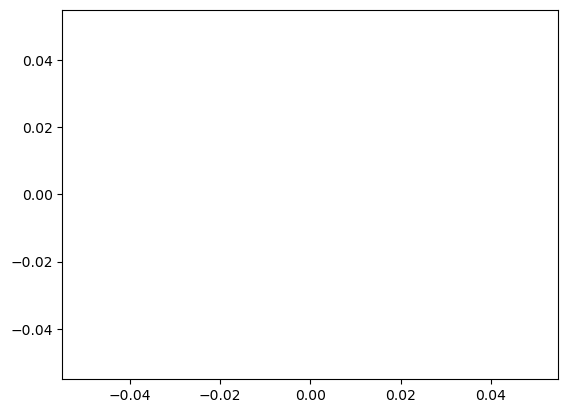

In [ ]:
plt.plot(model.losshistory)

In [ ]:
u00_1, v00_1, u00_2, v00_2 = model.predict1(test10_x,test10_t)
u11_1, v11_1, u11_2, v11_2 = model.predict1(testb_x1,testb_t1)
u22_1, v22_1, u22_2, v22_2 = model.predict1(testb_x2,testb_t2)
a1,b1,c1,d1, ux11_1, vx11_1, ux11_2, vx11_2 = model.predict2(testb_x1,testb_t1)
a1,b1,c1,d1, ux22_1, vx22_1, ux22_2, vx22_2 = model.predict2(testb_x2,testb_t2)

f1, f2, f3, f4,a1,b1,c1,d1 = model.predict2(testu_x,testu_t)     

C:\Users\npofsi\AppData\Local\Temp\ipykernel_2616\3934263755.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_2616\3934263755.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(Y, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_2616\3934263755.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\AppDat

In [ ]:
error_u0= ((np.linalg.norm(test10_r - u00_1, 2))**2+(np.linalg.norm(test10_c - v00_1, 2))**2+(np.linalg.norm(test20_r - u00_2, 2))**2+(np.linalg.norm(test20_c - v00_2, 2))**2)/20
error_ub= ((np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2+(np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2)/20
error_ubx= (
    (np.linalg.norm(ux11_1.cpu().detach().numpy() - ux22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_1.cpu().detach().numpy() - vx22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(ux11_2.cpu().detach().numpy() - ux22_2.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_2.cpu().detach().numpy() - vx22_2.cpu().detach().numpy(), 2))**2)/20

error_f= ((np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2+(np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2)/2000
print('Error_u0: %.5e, Error_ub: %.5e, Error_ubx: %.5e, Error_f: %.5e' % (error_u0.item(), error_ub.item(), error_ubx.item(), error_f.item()))




Error_u0: 2.15558e-02, Error_ub: 4.59042e-05, Error_ubx: 1.82287e-05, Error_f: 1.69915e-02


In [ ]:
print('loss: %.5e  lambda1: %.5e, lambda2: %.5e' % (model.best_loss,model.best_lambda_1, model.best_lambda_2))


loss: 1.54177e-01  lambda1: 9.57114e-01, lambda2: 2.04583e+00


In [ ]:
%%time
model.losshistory=[]            
model.train()

NameError: name 'model' is not defined